In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from imutils import paths

In [3]:
INIT_LR = 1e-4     #initial learning rate
EPOCHS = 20        #number of epochs to train for
BS = 32            #batch size

In [4]:
DIRECTORY = r"dataset"   #directory where the dataset is present
CATEGORIES = ["with_mask", "without_mask"]      #types of datasets


In [5]:
print("|+| Loading Images...")

|+| Loading Images...


In [6]:
data = []
labels = []

for category in CATEGORIES:
    path = os.path.join(DIRECTORY, category)
    for img in os.listdir(path):
    	img_path = os.path.join(path, img)
    	image = load_img(img_path, target_size=(250, 250))
    	image = img_to_array(image)
    	image = preprocess_input(image)

    	data.append(image)
    	labels.append(category)



C:\Users\ACER-SPIN 5\anaconda3\lib\site-packages\PIL\Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


In [7]:
lb = LabelBinarizer()     #converting data_category to one-hot encoding
labels = lb.fit_transform(labels)
labels = to_categorical(labels)

In [8]:
data = np.array(data, dtype="float32")
labels = np.array(labels)

In [9]:
(trainX, testX, trainY, testY) = train_test_split(data, labels,
	test_size=0.20, stratify=labels, random_state=42)

In [10]:
img_gen = ImageDataGenerator(rotation_range=20, zoom_range=0.15, width_shift_range=0.2, height_shift_range=0.2, shear_range=0.15)

In [11]:
bModel = MobileNetV2(weights="imagenet", include_top=False,
	input_tensor=Input(shape=(250, 250, 3)))

In [12]:
hModel = bModel.output
hModel = AveragePooling2D(pool_size=(7, 7))(hModel)
hModel = Flatten(name="flatten")(hModel)            #Flattening the layers
hModel = Dense(128, activation="relu")(hModel)
hModel = Dropout(0.5)(hModel)                       #to avoid overfitting
hModel = Dense(2, activation="softmax")(hModel)

In [13]:
model = Model(inputs=bModel.input, outputs=hModel)

for layer in bModel.layers:
	layer.trainable = False

In [14]:
print("|+| Compiling Model...")
op = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)
model.compile(loss="binary_crossentropy", optimizer=op,metrics=["accuracy"])

|+| Compiling Model...


In [ ]:
print("|+| Training Head...")
H = model.fit(img_gen.flow(trainX, trainY, batch_size=BS), steps_per_epoch=len(trainX) // BS, validation_data=(testX, testY), validation_steps=len(testX) // BS, epochs=EPOCHS)

|+| Training Head...
Epoch 1/20
95/95 [==============================] - 146s 2s/step - loss: 0.3597 - accuracy: 0.8431 - val_loss: 0.0975 - val_accuracy: 0.9831
Epoch 2/20
95/95 [==============================] - 140s 1s/step - loss: 0.1169 - accuracy: 0.9608 - val_loss: 0.0565 - val_accuracy: 0.9883
Epoch 3/20
95/95 [==============================] - 141s 1s/step - loss: 0.0750 - accuracy: 0.9779 - val_loss: 0.0435 - val_accuracy: 0.9883
Epoch 4/20
95/95 [==============================] - 143s 2s/step - loss: 0.0709 - accuracy: 0.9773 - val_loss: 0.0363 - val_accuracy: 0.9896
Epoch 5/20
95/95 [==============================] - 153s 2s/step - loss: 0.0553 - accuracy: 0.9782 - val_loss: 0.0338 - val_accuracy: 0.9896
Epoch 6/20
95/95 [==============================] - 148s 2s/step - loss: 0.0477 - accuracy: 0.9832 - val_loss: 0.0310 - val_accuracy: 0.9909
Epoch 7/20
65/95 [===================>..........] - ETA: 38s - loss: 0.0477 - accuracy: 0.9851

In [15]:
print("|+| Evaluating Network...")
predicting = model.predict(testX, batch_size=BS)  #prediction son testing set

|+| Evaluating Network...


In [16]:
predicting = np.argmax(predicting, axis=1)

In [17]:
print(classification_report(testY.argmax(axis=1), predicting, target_names=lb.classes_))

              precision    recall  f1-score   support

   with_mask       0.99      0.99      0.99       383
without_mask       0.99      0.99      0.99       384

    accuracy                           0.99       767
   macro avg       0.99      0.99      0.99       767
weighted avg       0.99      0.99      0.99       767



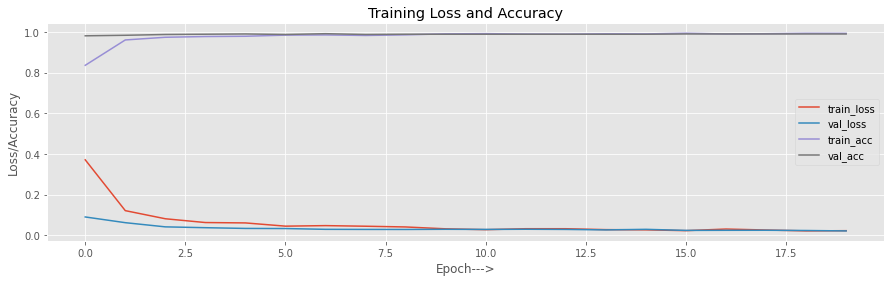

In [18]:
N = EPOCHS
plt.style.use("ggplot")
plt.figure(figsize=(15,4))
plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), H.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, N), H.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch--->")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="center right")

In [19]:
model.save('saved_model.h5')

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: models\cnn_model\assets
